In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
import re
from shutil import copy2
import ast
import cv2

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
import pocketsphinx

## Bag 1 : Classification Hijaiyah

### Memisahkan dataset sesuai label

In [ ]:
# memisahkan data di folder utama menjadi sub folder dengan warna tulisan hitam dan background putih
source_folder = r"C:\Users\gagah\Desktop\KKN\data\Train Images 13440x32x32\train"
destination_folder = r"C:\Users\gagah\Desktop\KKN\data\Data_Train_Images"

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
file_list = [f for f in os.listdir(source_folder) if f.endswith(".jpg") or f.endswith(".png")]

for filename in file_list:
    match = re.search(r'id_(\d+)_label_(\d+)', filename)
    if match:
        img_id = match.group(1)
        label = match.group(2)
        
        # Membuat path folder label
        label_folder = os.path.join(destination_folder, f'lab_{label}')
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        
        # Memuat dan menginversi gambar
        src_path = os.path.join(source_folder, filename)
        img = Image.open(src_path)
        img = ImageOps.invert(img)
        
        # Menyimpan gambar yang telah diubah ke folder tujuan dengan nama file baru
        dest_path = os.path.join(label_folder, f'id_{img_id}.png')
        img.save(dest_path)

### Labelling

In [2]:
with open('label_mapping.txt', 'r') as file:
    content = file.read()

# Find the positions of the two dictionaries
start1 = content.find('number_to_text')
end1 = content.find('}', start1) + 1
dict1_str = content[start1:end1]
number_to_text = ast.literal_eval(dict1_str.split('=')[1].strip())

start2 = content.find('lab_to_number')
end2 = content.find('}', start2) + 1
dict2_str = content[start2:end2]
lab_to_number = ast.literal_eval(dict2_str.split('=')[1].strip())

start3 = content.find('lab_to_text')
end3 = content.find('}', start3) + 1
dict3_str = content[start3:end3]
lab_to_text = ast.literal_eval(dict3_str.split('=')[1].strip())


### Menampilkan gambar dataset

Total data gambar: 480
Shape setiap gambar: (128, 128)


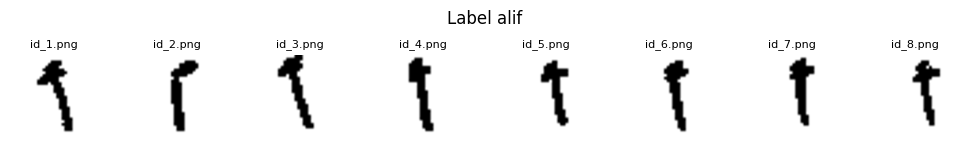

Total data gambar: 480
Shape setiap gambar: (128, 128)


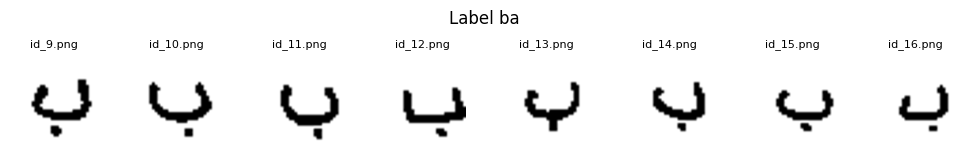

Total data gambar: 480
Shape setiap gambar: (128, 128)


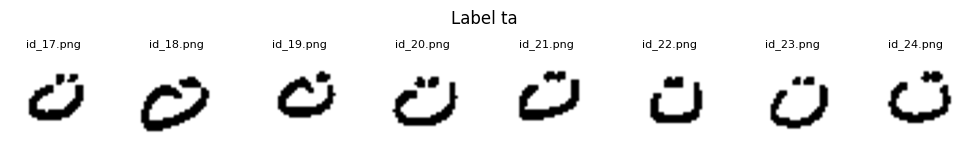

Total data gambar: 480
Shape setiap gambar: (128, 128)


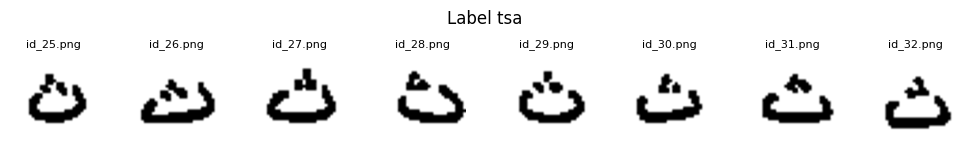

Total data gambar: 480
Shape setiap gambar: (128, 128)


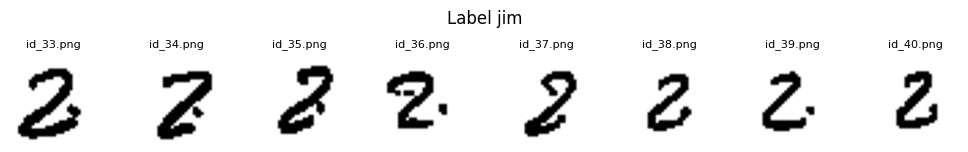

Total data gambar: 480
Shape setiap gambar: (128, 128)


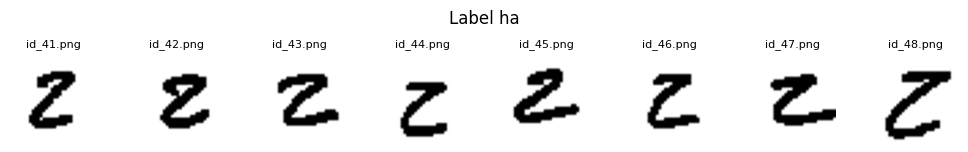

Total data gambar: 480
Shape setiap gambar: (128, 128)


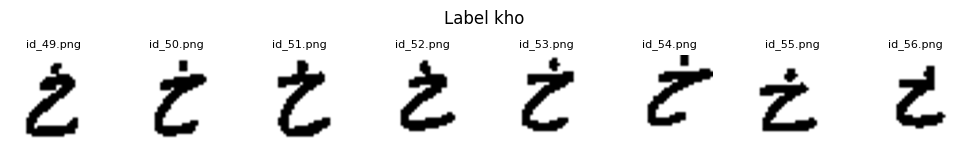

Total data gambar: 480
Shape setiap gambar: (128, 128)


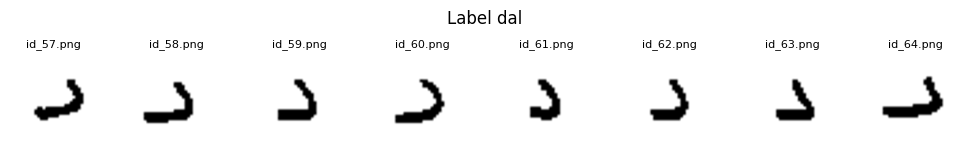

Total data gambar: 480
Shape setiap gambar: (128, 128)


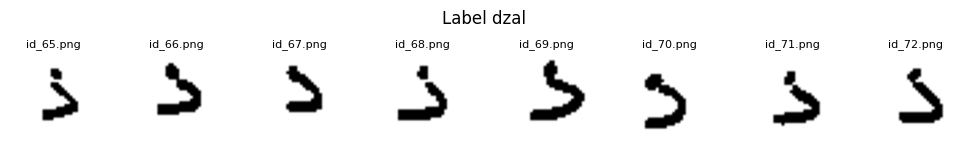

Total data gambar: 480
Shape setiap gambar: (128, 128)


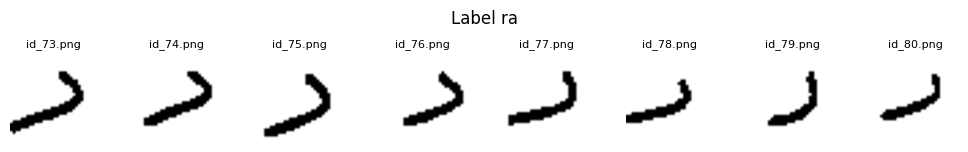

Total data gambar: 480
Shape setiap gambar: (128, 128)


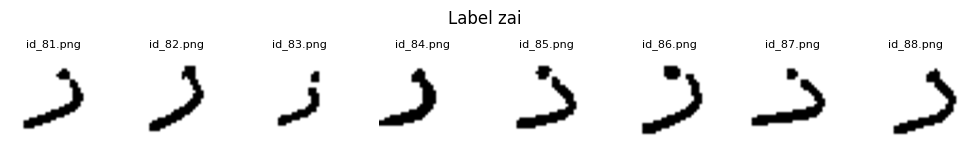

Total data gambar: 480
Shape setiap gambar: (128, 128)


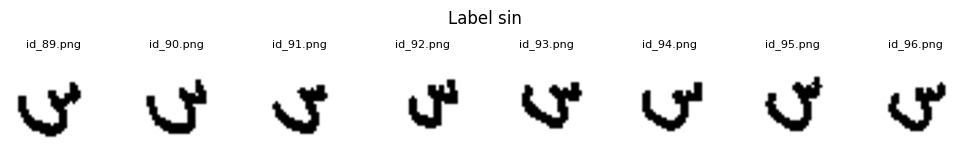

Total data gambar: 480
Shape setiap gambar: (128, 128)


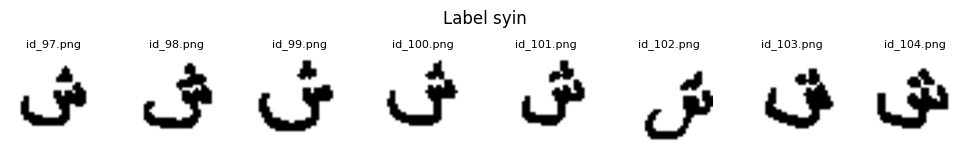

Total data gambar: 480
Shape setiap gambar: (128, 128)


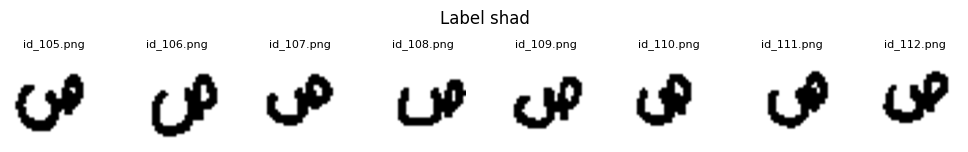

Total data gambar: 480
Shape setiap gambar: (128, 128)


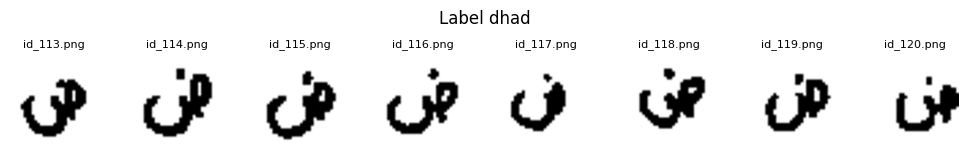

Total data gambar: 480
Shape setiap gambar: (128, 128)


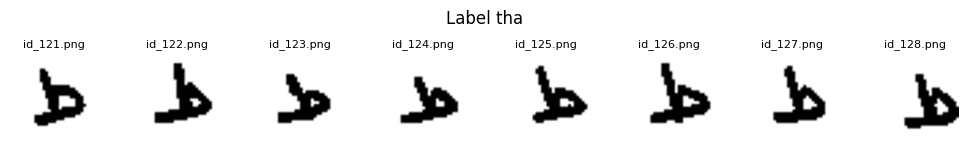

Total data gambar: 480
Shape setiap gambar: (128, 128)


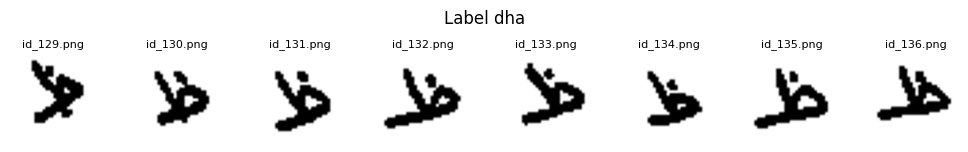

Total data gambar: 480
Shape setiap gambar: (128, 128)


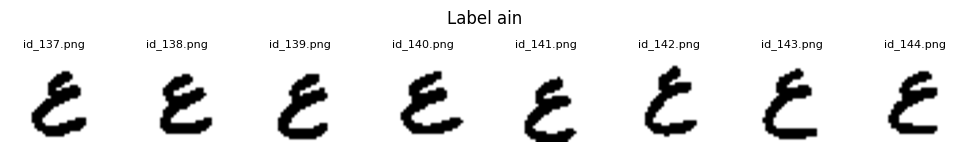

Total data gambar: 480
Shape setiap gambar: (128, 128)


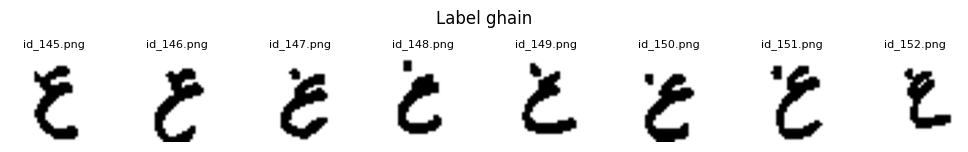

Total data gambar: 480
Shape setiap gambar: (128, 128)


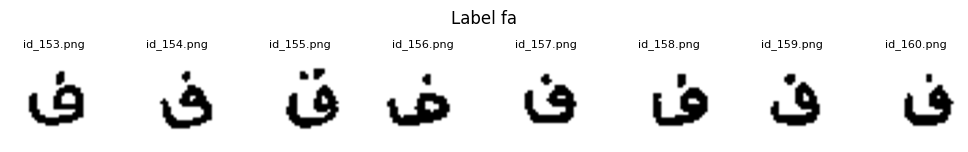

Total data gambar: 480
Shape setiap gambar: (128, 128)


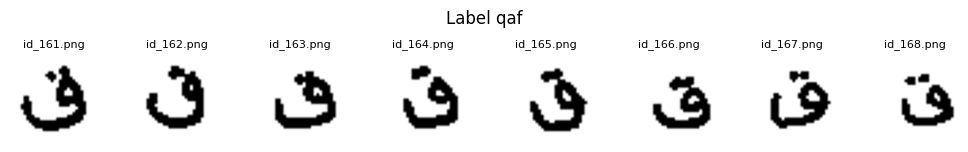

Total data gambar: 480
Shape setiap gambar: (128, 128)


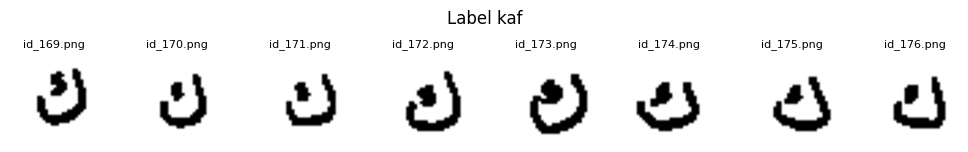

Total data gambar: 480
Shape setiap gambar: (128, 128)


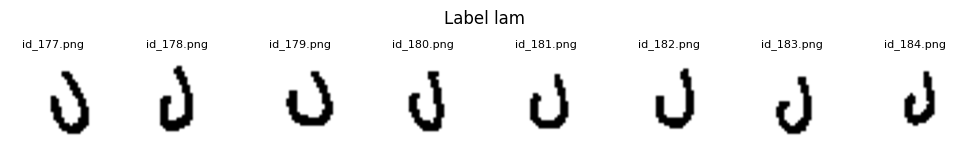

Total data gambar: 480
Shape setiap gambar: (128, 128)


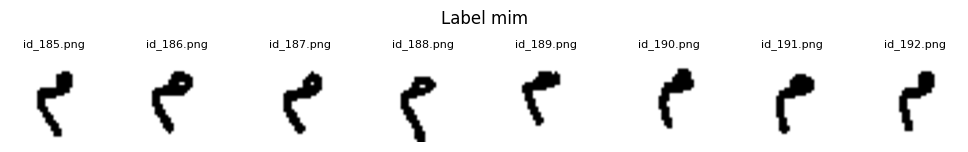

Total data gambar: 480
Shape setiap gambar: (128, 128)


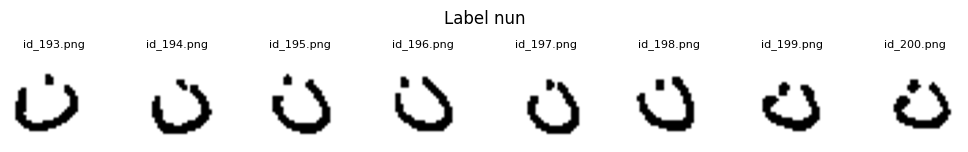

Total data gambar: 480
Shape setiap gambar: (128, 128)


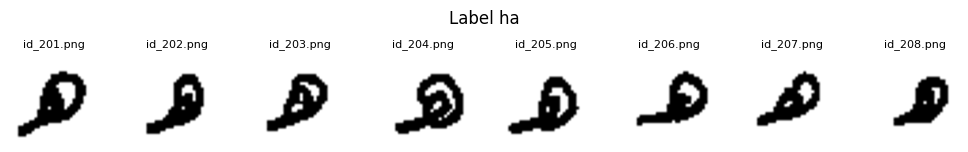

Total data gambar: 480
Shape setiap gambar: (128, 128)


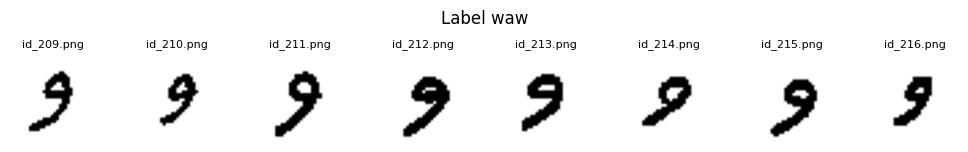

Total data gambar: 480
Shape setiap gambar: (128, 128)


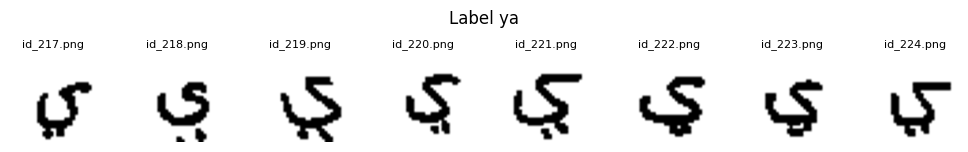

In [3]:
base_folder = "data\Data_Train_Images"
images_per_row = 8
size = 128

def extract_number(filename):
    match = re.search(r'_(\d+)', filename)
    return int(match.group(1)) if match else -1

folders = [f for f in os.listdir(base_folder)]
sorted_folders = sorted(folders, key=extract_number)

for label in sorted_folders:
    images_with_filenames = []
    
    label_directory = os.path.join(base_folder, label)
    file_list = [f for f in os.listdir(label_directory) if f.endswith(".png")]
    file_list.sort(key=extract_number)

    for filename in file_list:
        img_path = os.path.join(label_directory, filename)
        img = Image.open(img_path)
        img = img.resize((size, size))
        img_array = np.array(img)
        images_with_filenames.append((img_array, filename))

    images = np.array([img[0] for img in images_with_filenames])
    print(f'Total data gambar: {len(images)}')
    print(f'Shape setiap gambar: {images[0].shape}')

    # Plot the images
    fig, axes = plt.subplots(1, images_per_row, figsize=(10, 1.5))
    axes = axes.ravel()
    for i in range(8):
        axes[i].imshow(images_with_filenames[i][0], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(images_with_filenames[i][1], fontsize=8)

    plt.suptitle(f'Label {lab_to_text[label]}')
    plt.tight_layout()
    plt.show()


### Membuat model DeepLearning

In [4]:
model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.90:
                print("\nReached 93% accuracy so cancelling training!")
                print(f"accuracy : {logs.get('accuracy') * 100:.2f}% \n"
                      f"val_acc : {logs.get('val_accuracy') * 100:.2f}% \n")
                self.model.stop_training = True
    
datagen = ImageDataGenerator(
    rescale=1./255,
    #horizontal_flip=True,
    #vertical_flip=True,
    brightness_range=[0.5, 1.5],
    rotation_range=4,      # Meningkatkan rotation range
    shear_range=0.2,
    zoom_range=0.1,         # Menambahkan zoom range
    width_shift_range=0.2,  # Menambahkan width shift
    height_shift_range=0.2, # Menambahkan height shift
    fill_mode='nearest',    # Mode pengisian
    validation_split=0.2    # Split validation
)

train_generator = datagen.flow_from_directory(
    directory=base_folder,
    target_size=(size, size),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training' 
)

validation_generator = datagen.flow_from_directory(
    directory=base_folder,
    target_size=(size, size),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(size, size, 1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(folders), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'model_2_{epoch:02d}_{accuracy:.2f}_{val_accuracy:.2f}.h5'), 
    monitor='val_accuracy',    # Metrik yang dipantau
    save_best_only=True,       # Hanya menyimpan model terbaik
    mode='max',                # Mode 'max' karena kita ingin akurasi maksimum
    verbose=1                  # Menampilkan log setiap kali model disimpan
)

Found 10752 images belonging to 28 classes.
Found 2688 images belonging to 28 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                   

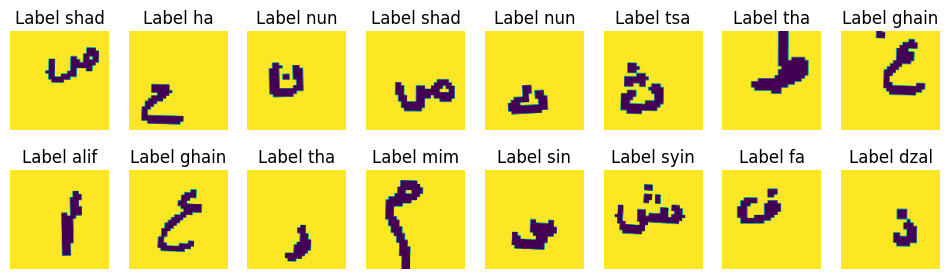

In [5]:
for images, labels in train_generator:
    plt.figure(figsize=(12, 3.3))
    for i in range(16):
        plt.subplot(2, 8, i+1)
        plt.imshow(images[i])
        plt.title(f'Label {number_to_text[labels[i].argmax()]}')
        plt.axis('off')
    plt.show()
    break

Epoch 1/100
336/336 [==============================] - ETA: 0s - loss: 3.1214 - accuracy: 0.0786
Epoch 1: val_accuracy improved from -inf to 0.22396, saving model to model\model_2_01_0.08_0.22.h5
336/336 [==============================] - 69s 200ms/step - loss: 3.1214 - accuracy: 0.0786 - val_loss: 2.4148 - val_accuracy: 0.2240
Epoch 2/100


c:\Users\gagah\Desktop\KKN\.conda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


336/336 [==============================] - ETA: 0s - loss: 1.8027 - accuracy: 0.3842
Epoch 2: val_accuracy improved from 0.22396 to 0.50967, saving model to model\model_2_02_0.38_0.51.h5
336/336 [==============================] - 68s 201ms/step - loss: 1.8027 - accuracy: 0.3842 - val_loss: 1.4139 - val_accuracy: 0.5097
Epoch 3/100
336/336 [==============================] - ETA: 0s - loss: 1.1647 - accuracy: 0.5982
Epoch 3: val_accuracy improved from 0.50967 to 0.68787, saving model to model\model_2_03_0.60_0.69.h5
336/336 [==============================] - 69s 206ms/step - loss: 1.1647 - accuracy: 0.5982 - val_loss: 0.9057 - val_accuracy: 0.6879
Epoch 4/100
336/336 [==============================] - ETA: 0s - loss: 0.8574 - accuracy: 0.7090
Epoch 4: val_accuracy improved from 0.68787 to 0.75037, saving model to model\model_2_04_0.71_0.75.h5
336/336 [==============================] - 74s 219ms/step - loss: 0.8574 - accuracy: 0.7090 - val_loss: 0.7254 - val_accuracy: 0.7504
Epoch 5/100
3

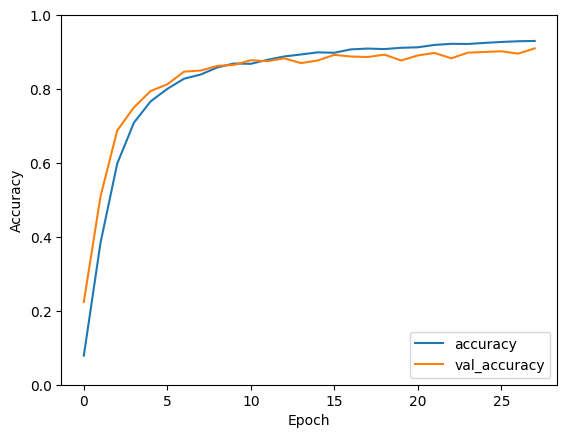

In [6]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, myCallback()]
)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

### Evaluation model

size = (128,128)
chanel = grayscale

420/420 [==============================] - 18s 42ms/step


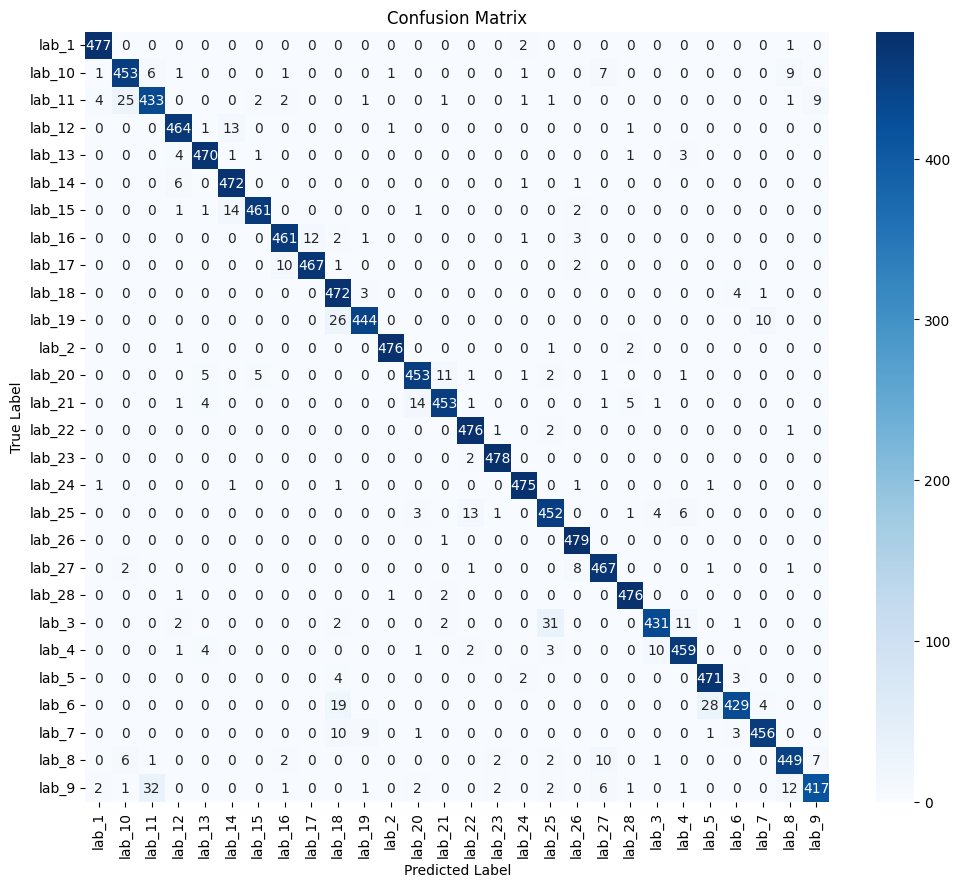

              precision    recall  f1-score   support

       lab_1       0.98      0.99      0.99       480
      lab_10       0.93      0.94      0.94       480
      lab_11       0.92      0.90      0.91       480
      lab_12       0.96      0.97      0.96       480
      lab_13       0.97      0.98      0.97       480
      lab_14       0.94      0.98      0.96       480
      lab_15       0.98      0.96      0.97       480
      lab_16       0.97      0.96      0.96       480
      lab_17       0.97      0.97      0.97       480
      lab_18       0.88      0.98      0.93       480
      lab_19       0.97      0.93      0.95       480
       lab_2       0.99      0.99      0.99       480
      lab_20       0.95      0.94      0.95       480
      lab_21       0.96      0.94      0.95       480
      lab_22       0.96      0.99      0.98       480
      lab_23       0.99      1.00      0.99       480
      lab_24       0.98      0.99      0.99       480
      lab_25       0.91    

In [7]:
label_mapping = {
    'lab_1': 'alif',
    'lab_2': 'ba',
    'lab_3': 'ta',
    'lab_4': 'tsa',
    'lab_5': 'jim',
    'lab_6': 'ha',
    'lab_7': 'kho',
    'lab_8': 'dal',
    'lab_9': 'dzal',
    'lab_10': 'ra',
    'lab_11': 'zai',
    'lab_12': 'sin',
    'lab_13': 'syin',
    'lab_14': 'shad',
    'lab_15': 'dhad',
    'lab_16': 'tha',
    'lab_17': 'dha',
    'lab_18': 'ain',
    'lab_19': 'ghain',
    'lab_20': 'fa',
    'lab_21': 'qaf',
    'lab_22': 'kaf',
    'lab_23': 'lam',
    'lab_24': 'mim',
    'lab_25': 'nun',
    'lab_26': 'ha',
    'lab_27': 'waw',
    'lab_28': 'ya'
}

def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, color_mode='grayscale', target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

def load_images_from_folders(base_folder):
    images = []
    labels = []
    class_names = os.listdir(base_folder)
    
    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(base_folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                if filename.endswith(".png"):
                    img_path = os.path.join(class_folder, filename)
                    img_array = load_and_preprocess_image(img_path)
                    images.append(img_array)
                    labels.append(class_index)
    
    images = np.vstack(images)  # Combine all images into one large array
    labels = np.array(labels)
    return images, labels, class_names

# Load the model
model = load_model('model/model_2_28_0.93_0.91.h5')

# Path to the dataset folder
base_folder = 'data/Data_Train_Images'

# Load and preprocess images
images, true_labels, class_names = load_images_from_folders(base_folder)

# Predict the class
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display confusion matrix with new labels
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report with new labels
print(classification_report(true_labels, predicted_classes, target_names=class_names))

1/1 [==============================] - 0s 63ms/step


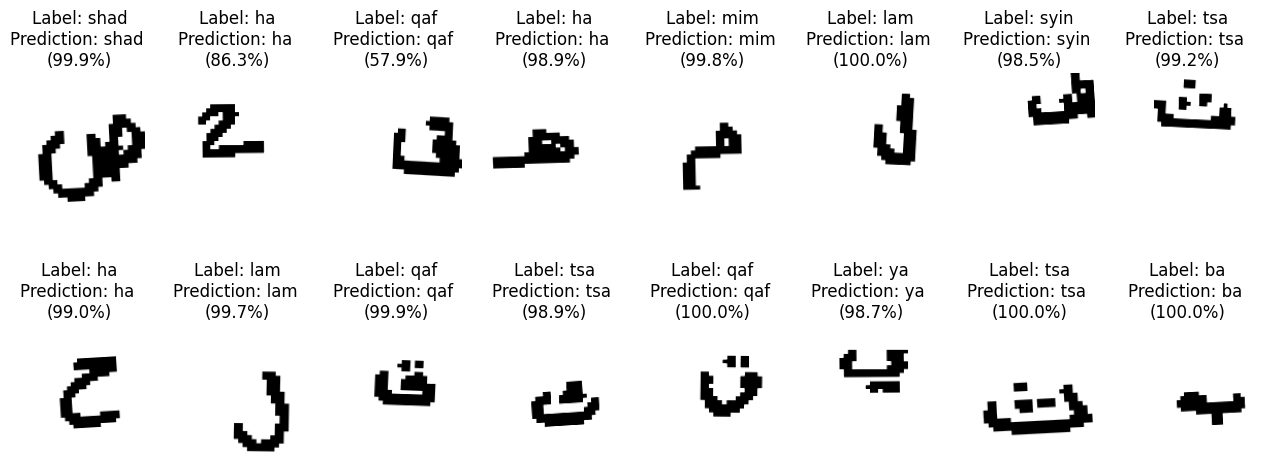

In [20]:
# Mengambil satu batch gambar dan label dari generator
for images, labels in train_generator:
    # Melakukan prediksi dengan model
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Membuat plot untuk menampilkan gambar dengan label asli dan prediksi
    plt.figure(figsize=(16, 6))
    for i in range(16):
        plt.subplot(2, 8, i+1)
        plt.imshow(images[i].reshape(images[i].shape[0], images[i].shape[1]), cmap='gray')
        plt.axis('off')        
        plt.title("Label: {}\nPrediction: {} \n({:.1f}%)".format(
        number_to_text[labels[i].argmax()], 
        number_to_text[predicted_classes[i]], 
        np.max(predictions[i]) * 100
    ))
    
    # Menampilkan plot
    plt.show()
    break


### coba pada data diluar dataset

1/1 [==============================] - 0s 31ms/step


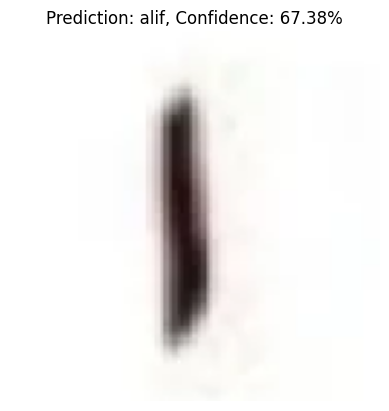

1/1 [==============================] - 0s 41ms/step


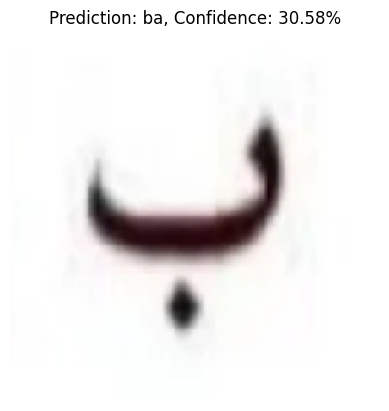

1/1 [==============================] - 0s 19ms/step


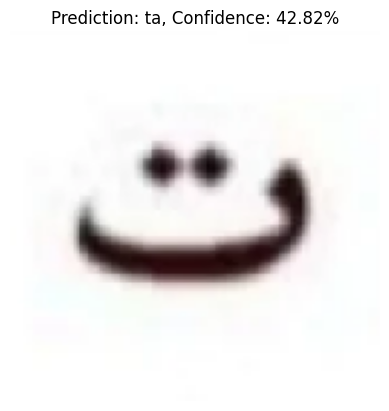

1/1 [==============================] - 0s 28ms/step


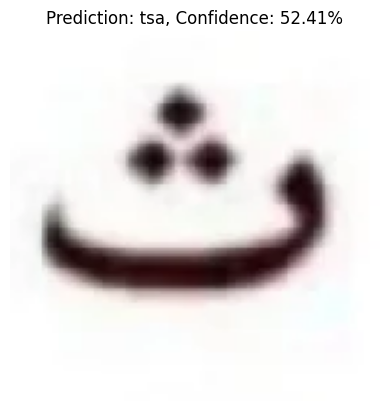

1/1 [==============================] - 0s 21ms/step


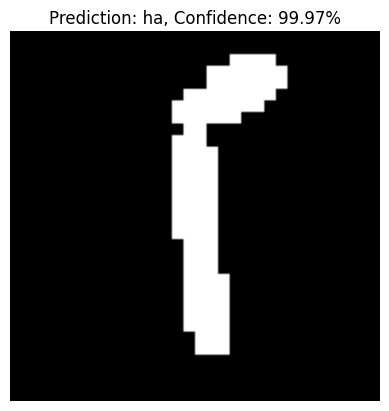

In [27]:
# Define image dimensions
img_height, img_width = 128, 128

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    # Load image with RGB mode
    img = load_img(image_path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Directory containing images
image_folder = 'example'

# Get list of image files
image_files = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.png')]

# Loop through each image, make predictions, and display results
for image_file in image_files:
    img_array = load_and_preprocess_image(image_file)
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction) * 100

    # Load the original image for display
    img = load_img(image_file, target_size=(img_height, img_width), color_mode='rgb')

    # Display the image and prediction
    plt.figure()
    plt.imshow(img)
    plt.title(f'Prediction: {number_to_text[predicted_label]}, Confidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()


### Ubah model menjadi TfLite

In [28]:
# Load model Keras (.h5)
model = tf.keras.models.load_model('model/model_2_28_0.93_0.91.h5')

# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TensorFlow Lite (.tflite)
with open('model_2_28_0.93_0.91.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke .tflite")

INFO:tensorflow:Assets written to: C:\Users\gagah\AppData\Local\Temp\tmpfuy2i57j\assets


INFO:tensorflow:Assets written to: C:\Users\gagah\AppData\Local\Temp\tmpfuy2i57j\assets


Model berhasil dikonversi ke .tflite
